In [31]:
%load_ext autoreload
%autoreload 2
import sys
import os
import joblib
from typing import Any
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder, rotation_feature_engineer, accelrometer_feature_engineer
from src.data_cleaning import clean_df
from src.utils.model_utils import evaulate_model, train_model
from src.utils.visualize_utils import plot_cm, get_avg_fold
from scipy.signal import butter, filtfilt, find_peaks, welch
from scipy.spatial.transform import Rotation
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

from scipy.spatial.transform import Rotation
from scipy.signal import find_peaks

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

tof_of_interest = ["tof_1_v20", "tof_2_v26", "tof_3_v17", "tof_4_v5", "tof_5_v20"]
full_df = full_df.drop(columns=[col for col in full_df.columns if col not in tof_of_interest and  col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_3_v17,tof_4_v5,tof_5_v20,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,57.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,68.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,97.0,107.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,151.0,113.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,207.0,121.0,192.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,219.0,93.0,46.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,216.0,82.0,50.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,208.0,83.0,53.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,210.0,91.0,48.0,1,30,0,1,186.0,55,30.0


In [ ]:
cleaned_df, target_gestures = clean_df(full_df, drop_rot_na=True, drop_thm_na=False, min_gesture_count=30)
cleaned_df = cleaned_df[cleaned_df['gesture'].isin(['Neck - scratch', 'Neck - pinch skin'])]

cleaned_df = rotation_feature_engineer(cleaned_df)
cleaned_df = accelrometer_feature_engineer (cleaned_df)

cleaned_df

[rot_na] Remaining: 254179/574945 (-320766, 55.8% dropped)
[gesture_len outliers] Remaining: 173855/254179 (-80324, 31.6% dropped)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,rotvec_x_diff,rotvec_z_diff,angular_mag,fft_acc_x,fft_acc_y,fft_acc_z,acc_mag,jerk_acc_x,jerk_acc_y,jerk_acc_z
518,SEQ_000034_000010,Target,SEQ_000034,10,SUBJ_063346,Lie on Back,Performs gesture,Gesture,Neck - pinch skin,-5.069893,...,0.000000,0.000000,0.000000,31796.0,85372.0,21215.0,17.002069,0.000000,0.000000,0.000000
519,SEQ_000034_000011,Target,SEQ_000034,11,SUBJ_063346,Lie on Back,Performs gesture,Gesture,Neck - pinch skin,-8.207284,...,-0.101658,-0.116572,0.166876,32.0,0.0,74.0,17.651459,-3.137391,0.020429,1.089872
520,SEQ_000034_000012,Target,SEQ_000034,12,SUBJ_063346,Lie on Back,Performs gesture,Gesture,Neck - pinch skin,-7.365990,...,0.129822,-0.090245,0.212338,3.0,1.0,11.0,18.382849,0.841294,-1.368959,-0.050580
521,SEQ_000034_000013,Target,SEQ_000034,13,SUBJ_063346,Lie on Back,Performs gesture,Gesture,Neck - pinch skin,-8.560902,...,-0.020919,-0.036545,0.042233,5.0,3.0,0.0,17.486109,-1.194912,1.634504,0.348853
522,SEQ_000034_000014,Target,SEQ_000034,14,SUBJ_063346,Lie on Back,Performs gesture,Gesture,Neck - pinch skin,-8.429194,...,-0.056152,-0.002792,0.056707,7.0,0.0,2.0,17.789941,0.131708,-0.496010,0.022810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574761,SEQ_065519_000079,Target,SEQ_065519,79,SUBJ_050642,Seated Straight,Performs gesture,Gesture,Neck - scratch,1.690747,...,0.000212,-0.003432,0.012323,3.0,0.0,5.0,11.417392,0.249331,0.498787,-0.780833
574762,SEQ_065519_000080,Target,SEQ_065519,80,SUBJ_050642,Seated Straight,Performs gesture,Gesture,Neck - scratch,2.485243,...,0.086266,-0.010570,0.098774,0.0,0.0,0.0,11.799657,0.794496,0.023147,0.450425
574763,SEQ_065519_000081,Target,SEQ_065519,81,SUBJ_050642,Seated Straight,Performs gesture,Gesture,Neck - scratch,1.998724,...,-0.026234,0.015445,0.030445,8.0,2.0,0.0,12.021725,-0.486520,0.182614,0.315651
574764,SEQ_065519_000082,Target,SEQ_065519,82,SUBJ_050642,Seated Straight,Performs gesture,Gesture,Neck - scratch,1.635719,...,-0.049929,-0.010939,0.056763,10.0,1.0,4.0,11.580454,-0.363004,-0.221930,-0.387939


In [101]:
agg_recipe = {
    "gesture": ["first"],
    "subject": ["first"],
    # ---Rotation
    "rotvec_x": ["mean", "std"],
    "rotvec_y": ["mean", "std"],
    "rotvec_z": ["mean", "std"],
    "rot_angle": ["mean", "std"],
    # angular velocity
    "rotvec_x_diff": ["mean", "std", "min", "max"],
    "rotvec_y_diff": ["mean", "std", "min", "max"],
    "rotvec_z_diff": ["mean", "std", "min", "max"],
    "angular_mag": ["mean", "std", "max"],  # dont' add min here, it was always zero
    # ---Accelrometer
    "acc_x": ["mean", "std"],
    "acc_y": ["mean", "std"],
    "acc_z": ["mean", "std"],
    "acc_mag": ["mean", "std"],
    # jerk
    "jerk_acc_x": ["mean", "std", "min", "max"],
    "jerk_acc_y": ["mean", "std", "min", "max"],
    "jerk_acc_z": ["mean", "std", "min", "max"],
    # fft stuff
    "fft_acc_x": ["mean", "std"],
    "fft_acc_y": ["mean", "std"],
    "fft_acc_z": ["mean", "std"],
    #
    # "thm_2": ["mean", "std"],
    # "thm_4": ["mean", "std"],
    # "thm_5": ["mean", "std"],
    # "thm_5": ["mean", "std"],
    # "tof_1_v20": ["mean", "std"],
}

filtered_df = cleaned_df.groupby("sequence_id")[list(agg_recipe.keys())].agg(agg_recipe)  # type: ignore
filtered_df.columns = ["_".join(col).strip() if col[1] else col[0] for col in filtered_df.columns.values]
filtered_df = filtered_df.rename(
    columns={
        "gesture_first": "target",
        "subject_first": "subject",
    }
)

# variance ratio
var_x = filtered_df["acc_x_std"] ** 2
var_y = filtered_df["acc_y_std"] ** 2
var_z = filtered_df["acc_z_std"] ** 2
total_var = var_x + var_y + var_z

filtered_df["var_x_ratio"] = var_x / total_var
filtered_df["var_y_ratio"] = var_y / total_var
filtered_df["var_z_ratio"] = var_z / total_var

# encoder
target_df = filtered_df["target"]
subject_df = filtered_df["subject"]
encoder = load_encoder(encoder_path, target_df)

target_np = torch.tensor(encoder.transform(target_df), dtype=torch.long).numpy()
features_np = torch.tensor(filtered_df.drop(columns=["target", "subject"]).to_numpy(), dtype=torch.float32).contiguous().numpy()

target_gestures_encoded = torch.tensor(encoder.transform(target_df))

filtered_df

,target,subject,rotvec_x_mean,rotvec_x_std,rotvec_y_mean,rotvec_y_std,rotvec_z_mean,rotvec_z_std,rot_angle_mean,rot_angle_std,...,jerk_acc_z_max,fft_acc_x_mean,fft_acc_x_std,fft_acc_y_mean,fft_acc_y_std,fft_acc_z_mean,fft_acc_z_std,var_x_ratio,var_y_ratio,var_z_ratio
sequence_id,,,,,,,,,,,,,,,,,,,,,
SEQ_000034,Neck - pinch skin,SUBJ_063346,1.584463,0.060351,-1.776774,0.086242,0.714039,0.085861,2.487867,0.076468,...,2.541327,1069.500000,5803.320380,2849.333333,15586.044964,721.333333,3870.693552,0.352120,0.138332,0.509548
SEQ_000166,Neck - pinch skin,SUBJ_063464,-0.707587,0.039567,0.166152,0.035927,1.599698,0.047309,1.758127,0.035740,...,1.827020,67.900000,355.687324,2765.600000,15147.437313,908.333333,4959.093683,0.493207,0.043937,0.462856
SEQ_000174,Neck - pinch skin,SUBJ_044680,1.101578,0.042410,-1.099721,0.126218,0.616674,0.089313,1.677306,0.123117,...,7.053196,2296.225806,12724.713921,1652.774194,9062.792751,335.096774,1433.515826,0.097518,0.220211,0.682271
SEQ_000284,Neck - pinch skin,SUBJ_000206,-0.397017,0.279437,-0.706167,0.434427,-2.475369,1.475592,3.023766,0.058423,...,5.631583,12.533333,43.599061,390.300000,2051.012805,46.100000,155.913183,0.126476,0.410715,0.462809
SEQ_000386,Neck - pinch skin,SUBJ_032704,1.231802,0.218870,-1.603310,0.108675,0.976073,0.132419,2.259494,0.102837,...,2.553287,1962.696970,11186.185787,2498.636364,14339.929994,321.212121,1717.712246,0.384854,0.064143,0.551004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQ_065266,Neck - pinch skin,SUBJ_017170,-0.132589,0.183306,-1.044069,0.771272,-2.415747,0.868757,2.867459,0.245506,...,6.579011,222.766667,311.316967,549.100000,2699.322729,514.166667,1833.673402,0.429079,0.136490,0.434431
SEQ_065430,Neck - pinch skin,SUBJ_054811,0.117832,0.078019,0.962013,0.075182,1.920570,0.028662,2.153468,0.052556,...,1.900906,834.387097,4594.451463,2834.096774,15775.128864,31.548387,123.179771,0.459185,0.056944,0.483871
SEQ_065478,Neck - scratch,SUBJ_052342,1.701673,0.024565,-1.638831,0.070175,1.003434,0.090497,2.568511,0.067212,...,1.241650,706.718750,3966.815601,2925.156250,16540.978381,532.031250,2944.614400,0.307972,0.074204,0.617825


Text(0.5, 1.0, 'scratch')

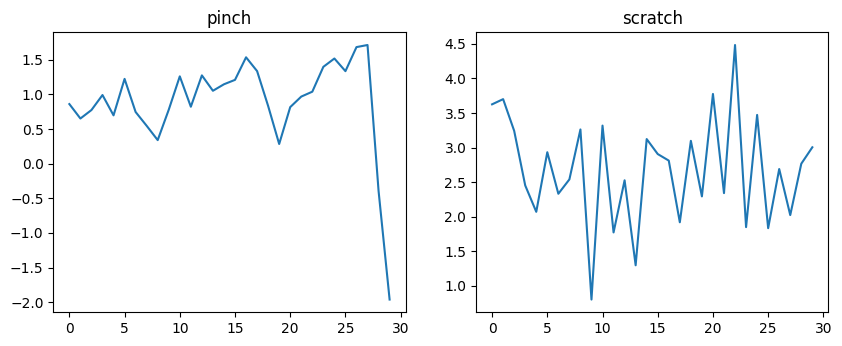

In [102]:
pinch_str = "Neck - pinch skin"
scratch_str = "Neck - scratch"

pinch_df = cleaned_df[cleaned_df["gesture"] == pinch_str]
scratch_df = cleaned_df[cleaned_df["gesture"] == scratch_str]

i = 6
feature_name = "acc_x"

pinch_seq = pinch_df[pinch_df["sequence_id"] == pinch_df["sequence_id"].unique()[i]]
scratch_seq = scratch_df[scratch_df["sequence_id"] == scratch_df["sequence_id"].unique()[i]]

plt.figure(figsize=(10, 8))

plt.subplot(221)
plt.plot(range(len(pinch_seq)), pinch_seq[feature_name])
plt.title("pinch")

plt.subplot(222)
plt.plot(range(len(scratch_seq)), scratch_seq[feature_name])
plt.title("scratch")

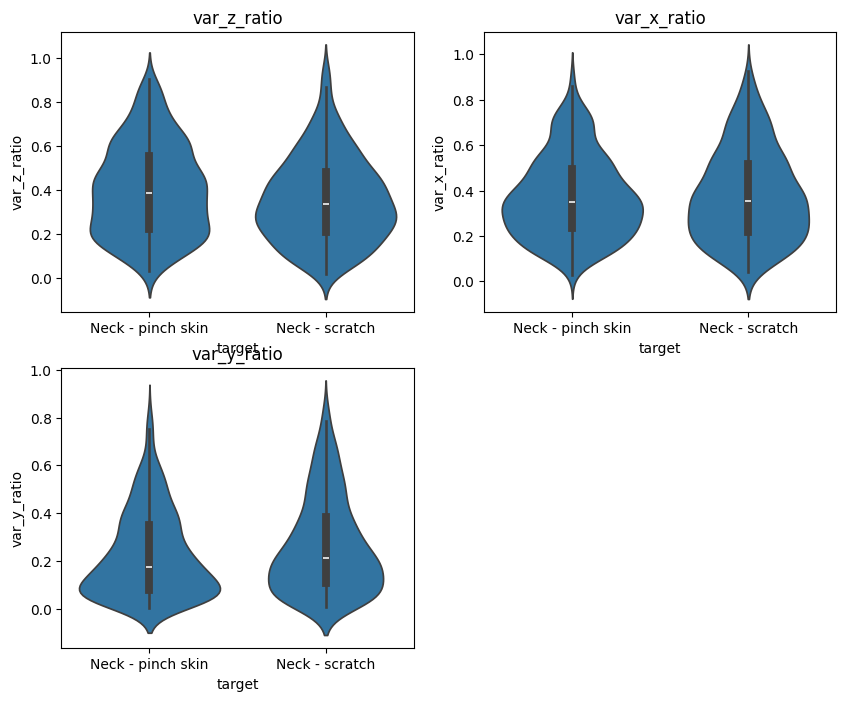

In [103]:
row, col = 2, 2

features = [
    'var_z_ratio',
    'var_x_ratio',
    'var_y_ratio'
]
plt.figure(figsize=(10, 8))

for i, feature in enumerate(features):
    plt.subplot(row, col, i + 1)
    sns.violinplot(filtered_df, x='target', y=feature)
    plt.title(feature)

In [104]:
n_splits = 4
gkf = GroupKFold(n_splits)

X_test_arr = []
X_train_arr = []
y_train_arr = []
y_test_arr = []
importances = []

test_subjects = []
folds_score = []
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_np, y=target_np, groups=subject_df)): # type: ignore
    print(f"\n------FOLD {fold + 1}/{n_splits}------\n")
    test_subjects.append(subject_df[test_indices].unique())
    X_train, y_train = features_np[train_indices], target_np[train_indices]
    X_test, y_test = features_np[test_indices], target_np[test_indices]
    
    lgbm = lgb.LGBMClassifier(random_state=42, n_estimators=200, learning_rate=0.1, num_leaves=31)
    lgbm.fit(X_train, y_train)
    
    X_train_arr.append(X_train)
    X_test_arr.append(X_test)
    y_train_arr.append(y_train)
    y_test_arr.append(y_test)
    
    y_pred = lgbm.predict(X_test)
    score_dashboard = evaulate_model(y_pred, y_test, target_gestures_encoded, encoder)
    importances.append(lgbm.feature_importances_)
    folds_score.append(score_dashboard)


------FOLD 1/4------

[LightGBM] [Info] Number of positive: 343, number of negative: 341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11901
[LightGBM] [Info] Number of data points in the train set: 684, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501462 -> initscore=0.005848
[LightGBM] [Info] Start training from score 0.005848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/tmp/ipykernel_804007/3521923366.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_804007/3521923366.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/tmp/ipykernel_804007/3521923366.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



------FOLD 3/4------

[LightGBM] [Info] Number of positive: 340, number of negative: 343
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11856
[LightGBM] [Info] Number of data points in the train set: 683, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497804 -> initscore=-0.008785
[LightGBM] [Info] Start training from score -0.008785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/tmp/ipykernel_804007/3521923366.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_subjects.append(subject_df[test_indices].unique())


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


macro: 0.612, binary: 1.000, competition: 0.806


,precision,recall,f1-score,support
Neck - pinch skin,0.606666,0.653963,0.628867,114.500000
Neck - scratch,0.621564,0.572606,0.595456,113.500000
accuracy,0.612959,0.612959,0.612959,0.612959
macro avg,0.614115,0.613285,0.612162,228.000000
weighted avg,0.614754,0.612959,0.612317,228.000000


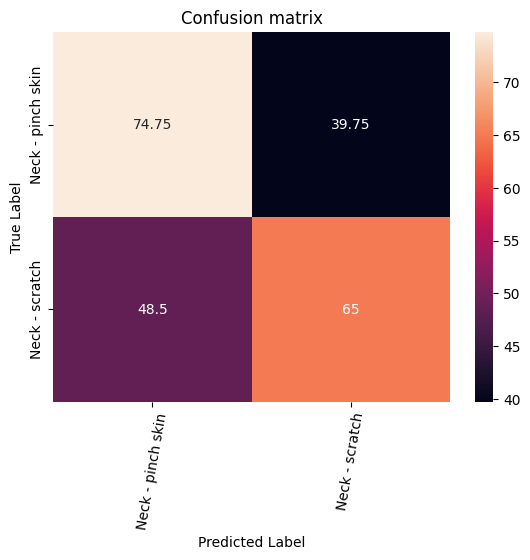

In [105]:
fold = get_avg_fold(folds_score)
# fold = folds_score[2]

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.3f}, binary: {binary:.3f}, competition: {competition_eval:.3f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

,feature,importance
20,angular_mag_mean,113.50
22,angular_mag_max,81.50
21,angular_mag_std,48.25


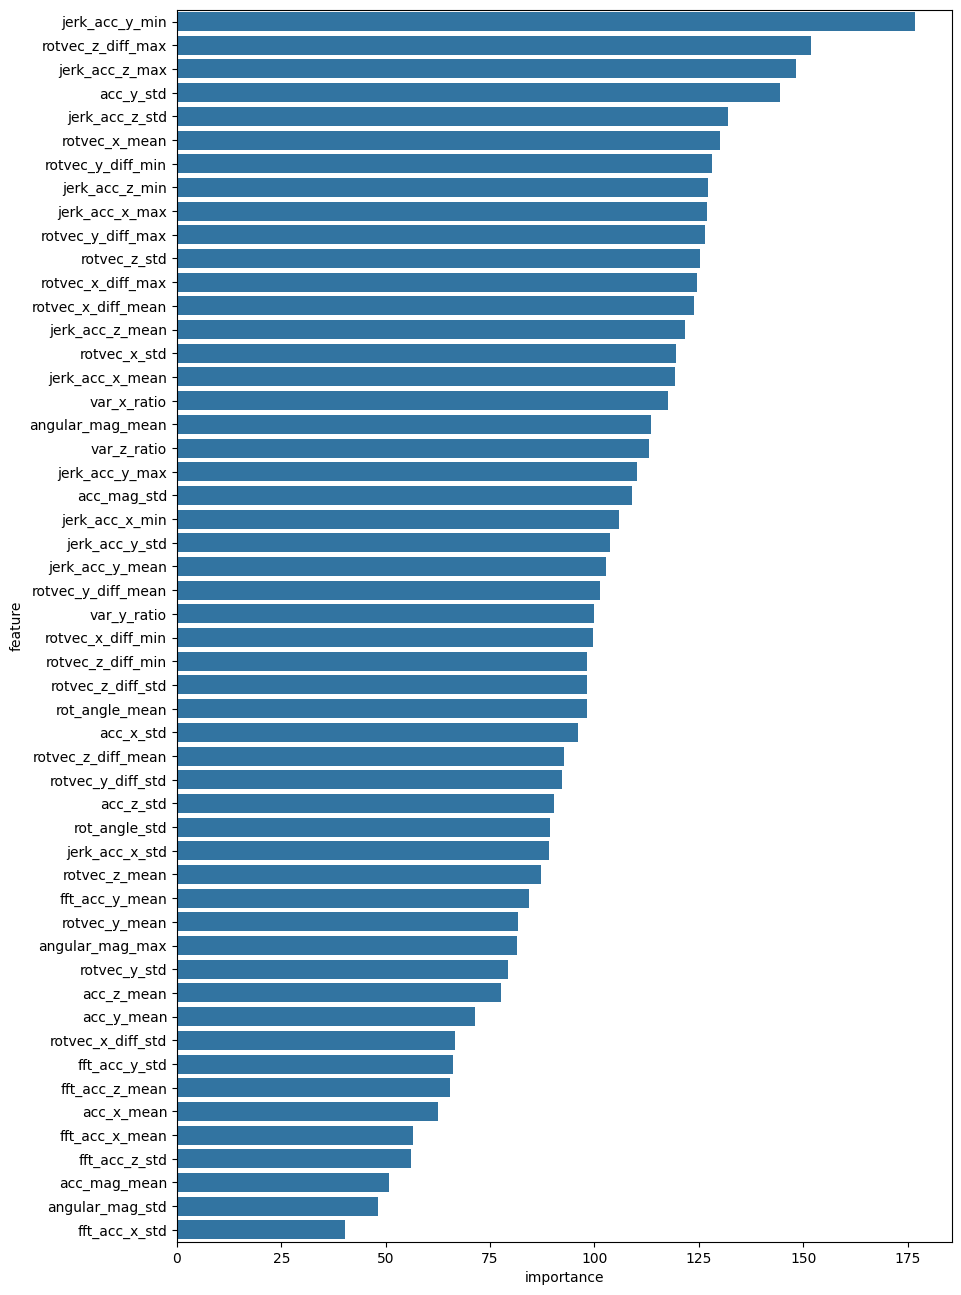

In [72]:
avg_importances =np.mean(importances, axis=0)
col_names = filtered_df.columns.drop(['subject', 'target'])
importance_df = pd.DataFrame({
    'feature': col_names,
    'importance': avg_importances,
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 16))
sns.barplot(importance_df, x='importance', y='feature')
plt.title("")

importance_df[importance_df['feature'].str.contains("angular")]

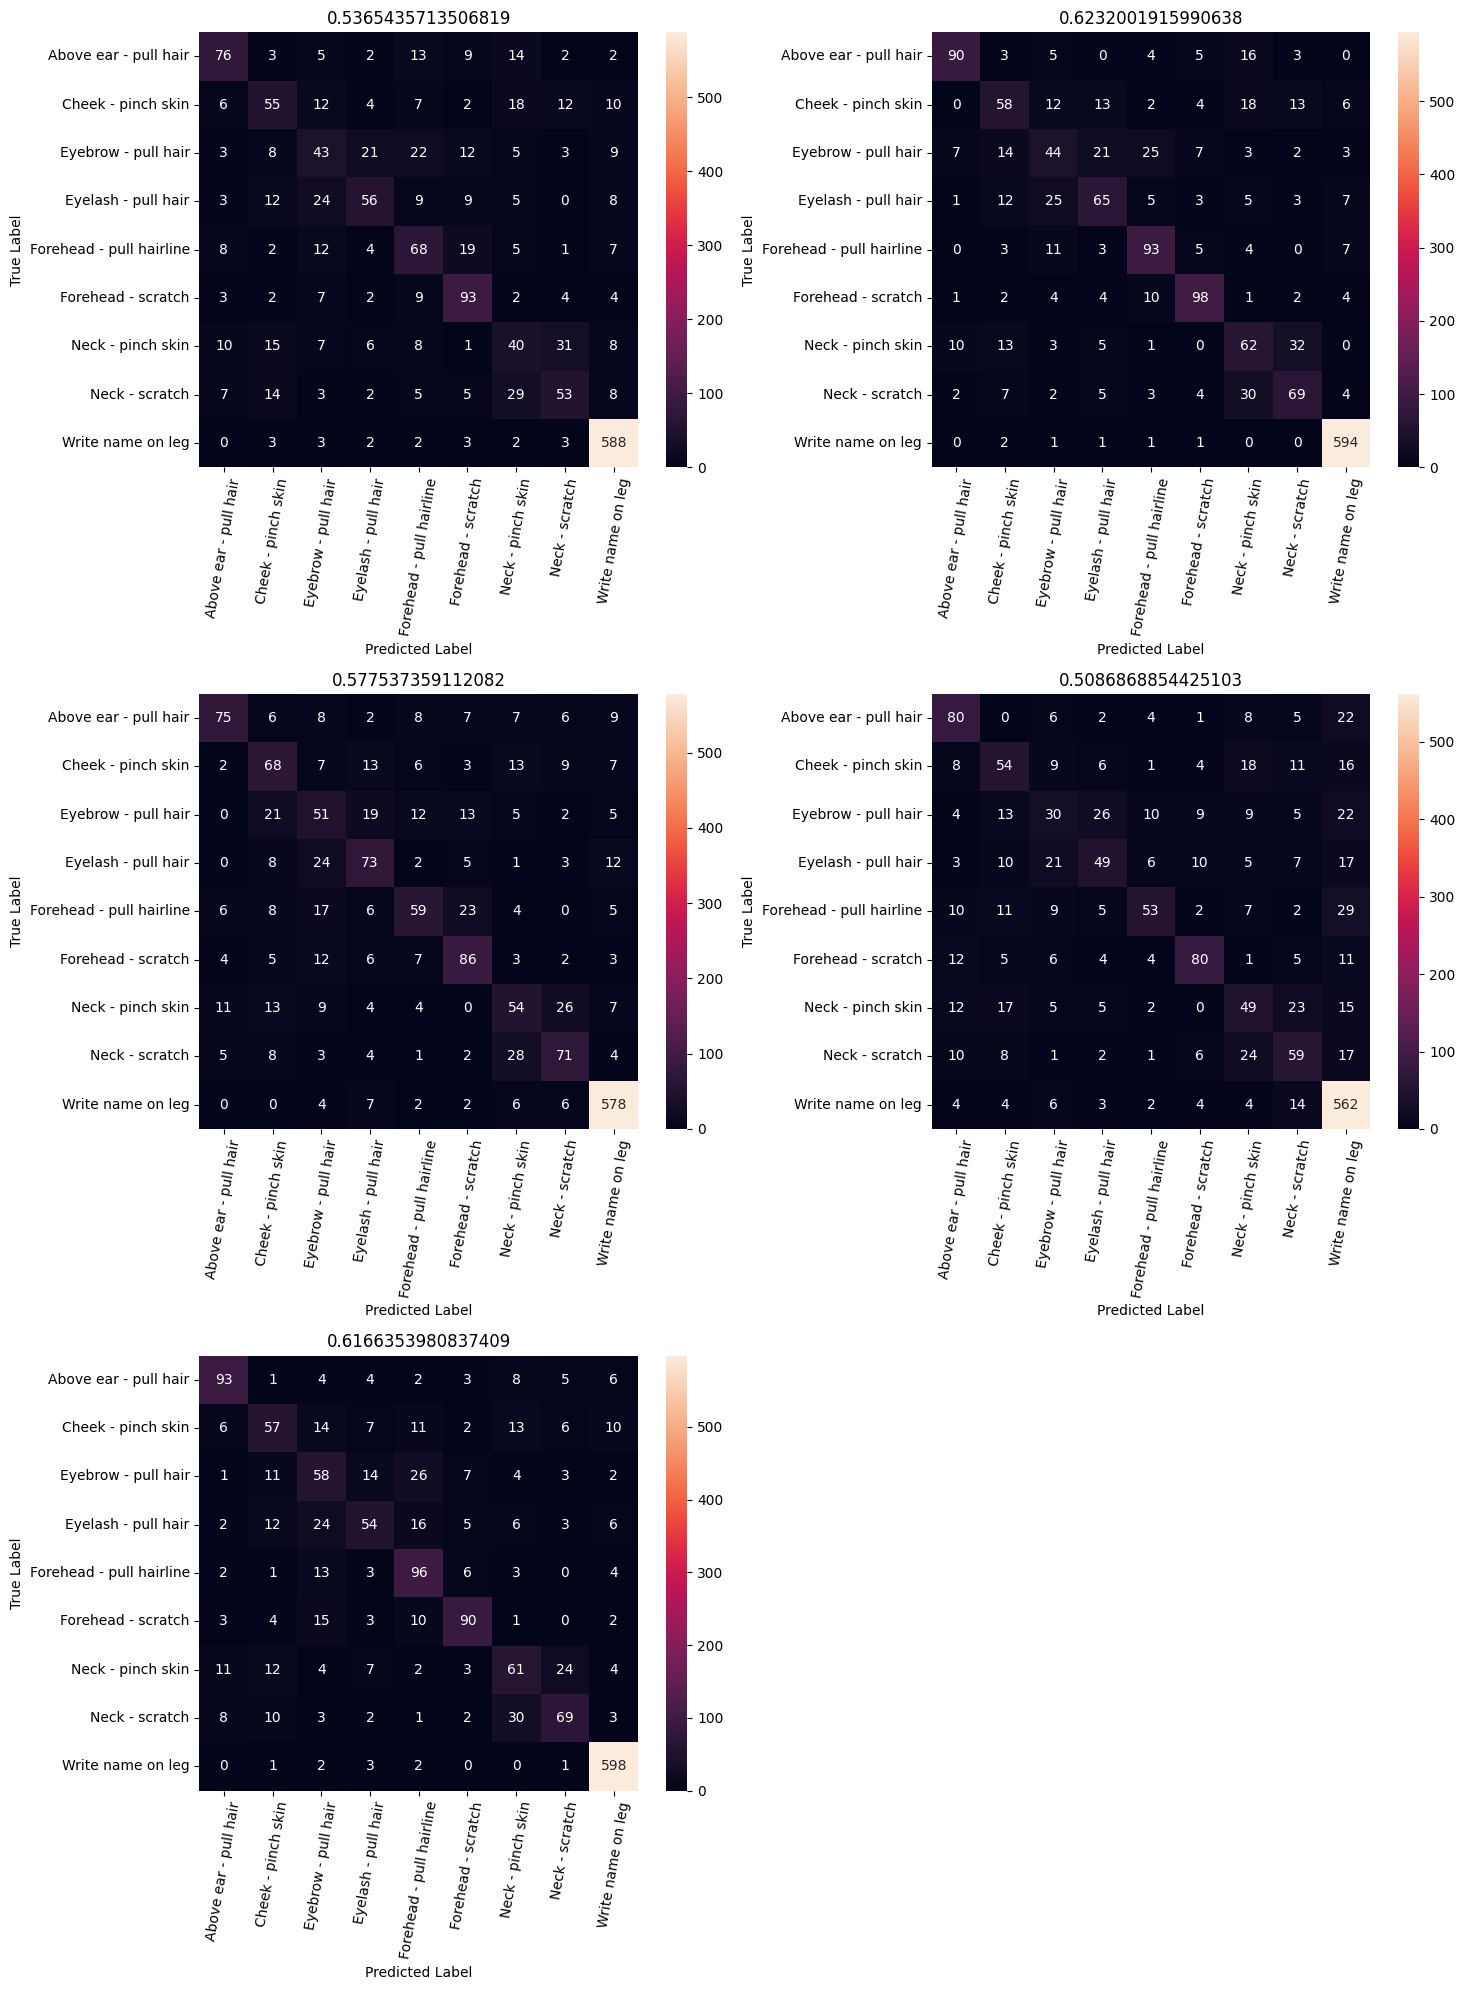

In [79]:
plt.figure(figsize=(15, 20))
for i, fold in enumerate(folds_score, start=1):
    plt.subplot(3, 2, i)
    plot_cm(fold["confusion_matrix"], list(encoder.classes_))
    plt.title(fold['f1_macro'])

plt.tight_layout()
# plt.subplots_adjust(hspace=0.8)

([<matplotlib.axis.XTick at 0x7b7dac5d2ba0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

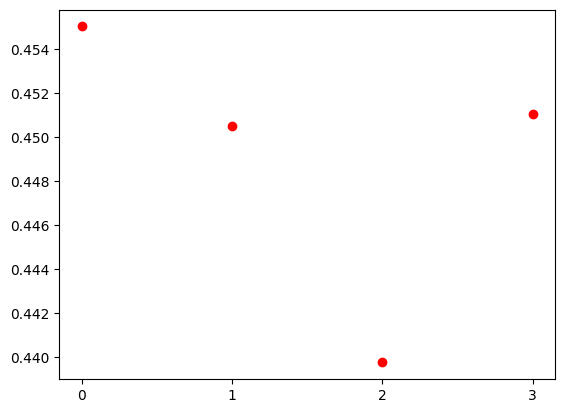

In [19]:
macros = [f["f1_macro"] for f in folds_score]
plt.plot(np.arange(len(macros)), macros, 'ro')
plt.xticks(np.arange(len(macros)))

# bad_idx = 2
# good_idx = 4

# print(f'good subjects: {test_subjects[good_idx]}')
# print(f'bad subjects: {test_subjects[bad_idx]}')